<a href="https://colab.research.google.com/github/Camicb/Anomaly-detection/blob/main/Travel_Insurance_Claim_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Travel Insurance Claim Prediction**

#1. Introduction

Many companies selling tickets or travel packages, give consumers the option to purchase travel insurance, also known as travelers insurance. Travel insurance is a type of insurance that covers the costs and losses associated with traveling. It is useful protection for those traveling domestically or abroad.
Some travel policies cover damage to personal property, rented equipment, such as rental cars, or even the cost of paying a ransom. 

The objective of this project is to create a machine learning model for a insurance company to predict if the insurance buyer will claim their travel insurance or not.

This project was part of an assignment for a Machine Learning Bootcamp conducted by [DPhi](https://dphi.tech/) last year. The datasets were provided freely by them.

#2. Import Required Libraries

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip -q
!pip install scikit-plot -q
!pip install -U imbalanced-learn -q
!pip install delayed -q
!pip install lightgbm -q

In [2]:
#Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from pandas_profiling import ProfileReport
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [3]:
np.random.seed(2021) # A seed for reproducibility

#3. Exploratory Data Analysis
##3.1 About the data
There are 11 columns in the dataset:
*   **Duration:** Travel duration
*   **Destination:** Travel destination (country)
*   **Agency:** Agency Name
*   **Agency Type:** Travel Agency or Airlines 
*   **Commission (in value):** Commission on the insurance
*   **Age:** Age of the insurance buyer
*   **Gender:** Gender of the insurance buyer
*   **Distribution Channel:** offline/online
*   **Product Name:** Name of the insurance plan
*   **Net Sales:** Net sales
*   **Claim:** If the insurance is claimed or not (the target variable), 0 = not claimed, 1 = claimed


In [4]:
# Load the provided data into a pandas data frame 
ins = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Training_set_label.csv" ) # training data
test_ins = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Testing_set_label.csv') # testing data

## 3.2 Exploratory data analysis

In [5]:
ins.head()
print(' ')
ins.info()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,11.88,NaN,29,0
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,0.00,NaN,36,0
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,0.00,NaN,25,0
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,13.63,M,24,0
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,0.00,NaN,23,0


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                48260 non-null  object 
 1   Agency Type           48260 non-null  object 
 2   Distribution Channel  48260 non-null  object 
 3   Product Name          48260 non-null  object 
 4   Duration              48260 non-null  int64  
 5   Destination           48260 non-null  object 
 6   Net Sales             48260 non-null  float64
 7   Commision (in value)  48260 non-null  float64
 8   Gender                13899 non-null  object 
 9   Age                   48260 non-null  int64  
 10  Claim                 48260 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 4.1+ MB


In [6]:
test_ins.head()
print(' ')
test_ins.info()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,EPX,Travel Agency,Online,Cancellation Plan,24,HONG KONG,27.0,0.0,NaN,36
1,EPX,Travel Agency,Online,Cancellation Plan,51,JAPAN,45.0,0.0,NaN,36
2,EPX,Travel Agency,Online,Cancellation Plan,52,JAPAN,21.0,0.0,NaN,21
3,EPX,Travel Agency,Online,Cancellation Plan,89,SINGAPORE,11.0,0.0,NaN,30
4,EPX,Travel Agency,Online,Cancellation Plan,5,MALAYSIA,10.0,0.0,NaN,33


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15832 entries, 0 to 15831
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                15832 non-null  object 
 1   Agency Type           15832 non-null  object 
 2   Distribution Channel  15832 non-null  object 
 3   Product Name          15832 non-null  object 
 4   Duration              15832 non-null  int64  
 5   Destination           15832 non-null  object 
 6   Net Sales             15832 non-null  float64
 7   Commision (in value)  15832 non-null  float64
 8   Gender                4546 non-null   object 
 9   Age                   15832 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 1.2+ MB


In [7]:
# Statistic report
profile = ProfileReport(ins, html={'style': {'full_width': True, 'primary_color': '#30b6c2'}},  samples=None, missing_diagrams=None, interactions=None)
profile.to_file("report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

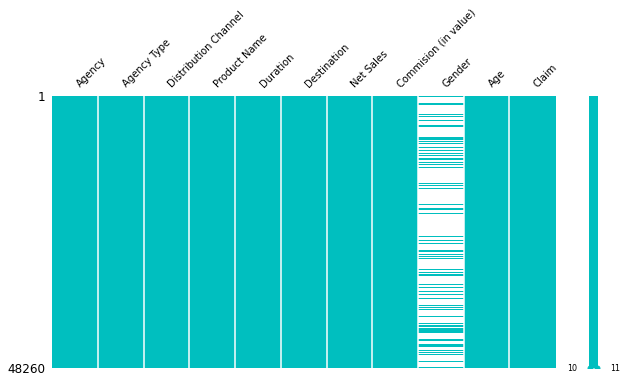

In [8]:
# Visualization of missing values 
msno.matrix(ins, figsize=(10,5), fontsize=10, color=(0.0, 0.75, 0.75)) 

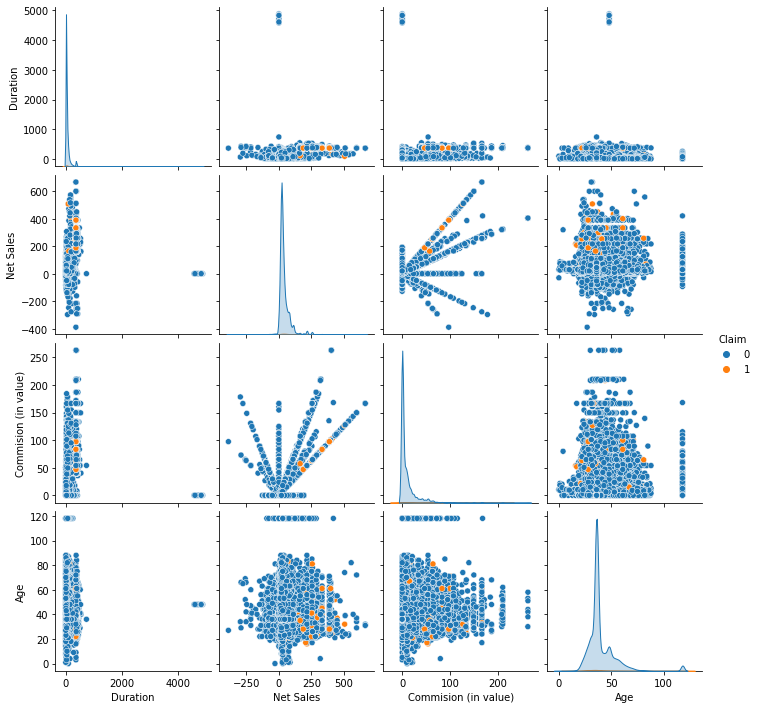

In [9]:
# Relations betwwen variables
sns.pairplot(ins, hue='Claim')

# 4. Preprocessing and feature engineering

Changes in the testing data are executed in order to maintain a consistent shape with the training data. Since 'Gender' has too many missing values and the 'Distribution Channel' is highly correlated to others variables and presents imbalanced classes, the entire columns will be removed. Outliers will be removed too. A new category, 'Other', will be created for attributes with smaller frequencies along the variables, in order to decreased the number of columns that will be created after one hot encoding the categorical variables.


In [10]:
# Droping irrelevants columns
ins.drop(['Gender', 'Distribution Channel'], axis=1, inplace=True)
test_ins.drop(['Gender', 'Distribution Channel'], axis=1, inplace=True)

# Transforming outliers into NaN for posterior imputation
ins['Duration']= ins.loc[:, 'Duration'].apply(lambda x: np.nan if x < 1 else x)
ins['Age']= ins.loc[:,'Age'].apply(lambda x: np.nan if x == 118 else x)

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

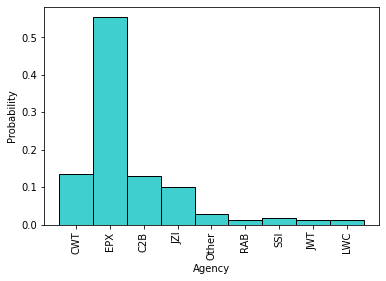

In [11]:
# AGENCY

# Replacing the agencies with a frequency smaller than 1% with 'Other' 
Agencies=ins.loc[:,'Agency'].value_counts(normalize=True)*100
Agencies=list(Agencies[Agencies < 1].index)
ins.loc[:,'Agency']=ins.loc[:,'Agency'].apply(lambda i: 'Other' if i in Agencies else i)
test_ins.loc[:,'Agency']=test_ins.loc[:,'Agency'].apply(lambda i: 'Other' if i in Agencies else i)
sns.histplot(data=ins, x='Agency', color='c', stat='probability') # plot new categories
plt.xticks(rotation='vertical')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

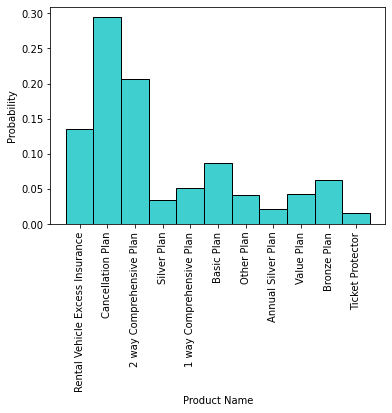

In [12]:
# PRODUCT NAME

# Replacing the products with a frequency smaller than 1% with 'Other Plan' 
Products=ins.loc[:, 'Product Name'].value_counts(normalize=True)*100
Products=list(Products[Products < 1].index)
ins['Product Name']=ins['Product Name'].apply(lambda i: 'Other Plan' if i in Products else i)
test_ins['Product Name']=test_ins['Product Name'].apply(lambda i: 'Other Plan' if i in Products else i)
sns.histplot(data=ins, x='Product Name', color='c', stat='probability')  # plot new categories
plt.xticks(rotation='vertical')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text major ticklabel objects>)

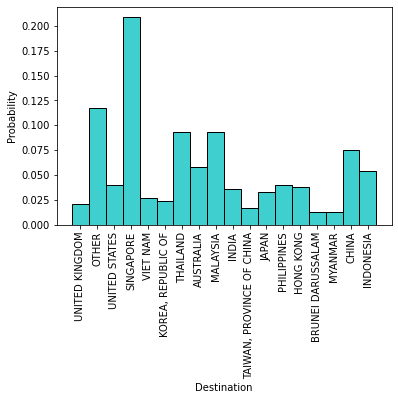

In [13]:
# DESTINATION

# Replacing the Destinations with a frequency smaller than 1% to 'OTHER'
Destination=ins.loc[:, 'Destination'].value_counts(normalize=True)*100
Destination=list(Destination[Destination > 1].index)

ins['Destination']=ins['Destination'].apply(lambda i: 'OTHER' if i not in Destination else i)
test_ins['Destination']=test_ins['Destination'].apply(lambda i: 'OTHER' if i not in Destination else i)

sns.histplot(data=ins, x='Destination', color='c', stat='probability')  # plot new categories
plt.xticks(rotation='vertical')


In [14]:
# Checking the shape of the data for modeling
ins.shape
test_ins.shape

(48260, 9)

(15832, 8)

# 5. Modeling experiments
As it's seen in the Statistical Report, the positive cases (1) of 'Claim' are only 1.5% of the target variable. To deal with these highly imbalanced classes, I will consider two approaches: oversampling the minority class and outlier/anomaly detection techniques. 

In [15]:
# Function for preprocessing the data

def prep(X):

  num_var = X[['Duration', 'Net Sales', 'Commision (in value)', 'Age']]
  cat_var = X[['Agency', 'Agency Type', 'Product Name', 'Destination']]

  # Imputing missing values
  imputed= SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(num_var)
  imputed = pd.DataFrame(data=imputed)
  imputed.columns= num_var.columns
  
  # One hot encoding categorial variables
  one = pd.get_dummies(cat_var, columns=cat_var.columns, drop_first=True)

  # Join
  join = pd.concat([imputed, one], axis=1)

  # Standarizing data
  scaled_features = StandardScaler().fit_transform(join)
  scaled_features = pd.DataFrame(data=scaled_features)
  scaled_features.columns= join.columns
  
  return scaled_features

In [16]:
# Spliting data into training and validation datasets

X = prep(ins)
y = ins['Claim']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y, random_state=2021)
X_test = prep(test_ins)
# y_test is on the Dphi site

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(38608, 40) (38608,)
(9652, 40) (9652,)
(15832, 40)


## 5.1 Modeling with oversampling
I will use LightGBM as classifier and [SMOTE](https://imbalanced-learn.org/stable/over_sampling.html) for oversampling the data.

In [17]:
# Fixing columns name since LGBM don't support special JSON characters
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [18]:
# Oversampling with SMOTE (50% of minority class)
X_resampled, y_resampled = SMOTE(sampling_strategy=0.5).fit_resample(X_train, y_train)
y_resampled.value_counts()

0    38042
1    19021
Name: Claim, dtype: int64

In [19]:
# Classification with oversampling
clf = lgb.LGBMClassifier(objective='binary', n_jobs=-1, learning_rate=0.1, reg_alpha=0.5)
clf.fit(X_resampled, y_resampled)
y_pred_clf = clf.predict(X_val)
print(' ')
print("Weighted F1 score on test set: "
         "%0.3f" % f1_score(y_val, y_pred_clf, average='weighted'))

LGBMClassifier(objective='binary', reg_alpha=0.5)

 
Weighted F1 score on test set: 0.966


In [20]:
# Classification report
target_names=['0','1']
print(classification_report(y_val, y_pred_clf, target_names=target_names))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      9510
           1       0.10      0.25      0.14       142

    accuracy                           0.96      9652
   macro avg       0.55      0.61      0.56      9652
weighted avg       0.98      0.96      0.97      9652



Results seem better now, but I will check with plots and other metrics.

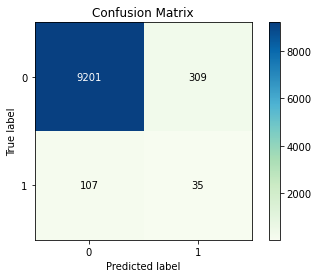

In [21]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_val, y_pred_clf, cmap='GnBu')


In [22]:
# Confusion Matrix percentages
confusion_matrix(y_val, y_pred_clf, normalize='all')

array([[0.95327393, 0.03201409],
       [0.01108579, 0.00362619]])

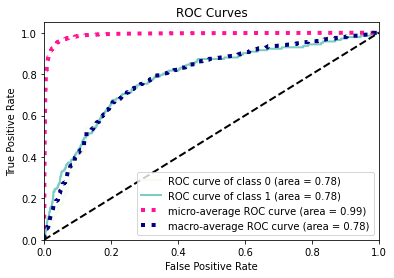

In [23]:
# ROC - AUC Curves
y_probas = clf.predict_proba(X_val)
skplt.metrics.plot_roc(y_val, y_probas, cmap='GnBu')
plt.show()

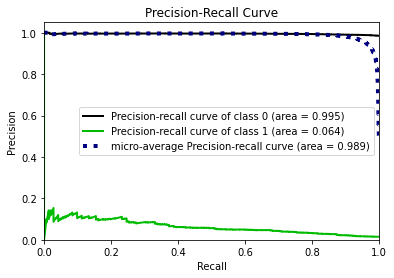

In [24]:
# Precision - recall curve
skplt.metrics.plot_precision_recall(y_val, y_probas)

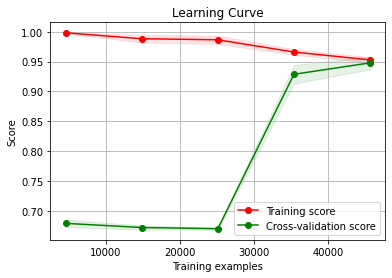

In [25]:
# Learning curve
skplt.estimators.plot_learning_curve(clf, X_resampled, y_resampled)

The model created is good in classifying the majority class, 0 or 'don't claim', but fails in classify the minority 1 or 'claim'. So instead of tuning the hyperparameters of this model, I will create new ones with more appropriate algorithms.

## 5.2 Modeling with Isolation Forest

Isolation forest is an unsupervised algorithm for anomaly detection that works on principle of isolating anomalies. Instead of trying to build a model of normal instances, it explicitly isolates anomalous points in the dataset. It is a very fast algorithm with a low memory demand.

In [26]:
# Calculating outlier fraction
df = pd.concat([X_train, y_train], axis=1)
claim = df[df['Claim'] == 1] # Number of positives cases
no_claim = df[df['Claim'] == 0] # Number of negative cases
outlier_fraction = len(claim)/float(len(no_claim))
outlier_fraction

0.014878292413648074

In [27]:
# Creating model
from sklearn.ensemble import IsolationForest

isf = IsolationForest(max_samples = len(X_train), contamination = outlier_fraction, n_estimators=1000, random_state=2021, n_jobs=-1)
isf.fit(X_train, y_train)
y_pred_isf = isf.predict(X_val)
print(' ')
print("Weighted F1 score on test set: "
         "%0.3f" % f1_score(y_val, y_pred_isf, average='weighted', zero_division=1))


IsolationForest(contamination=0.014878292413648074, max_samples=38608,
                n_estimators=1000, n_jobs=-1, random_state=2021)

 
Weighted F1 score on test set: 0.000


In [28]:
# Anomaly score of the input samples. The lower, the more abnormal
isf.score_samples(X_val)

array([-0.33009507, -0.36996443, -0.35797553, ..., -0.46081413,
       -0.36990492, -0.40635573])

In [29]:
# Classification report
print(classification_report(y_val, y_pred_isf, zero_division=1))

              precision    recall  f1-score   support

          -1       0.00      1.00      0.00         0
           0       1.00      0.00      0.00      9510
           1       0.01      0.98      0.03       142

    accuracy                           0.01      9652
   macro avg       0.34      0.66      0.01      9652
weighted avg       0.99      0.01      0.00      9652



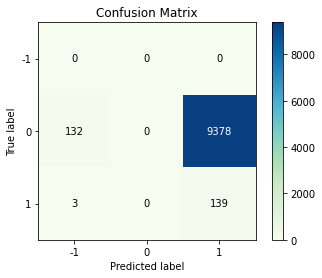

In [30]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_val, y_pred_isf, cmap='GnBu')

As the metrics show, Isolation forests don't perform well in this particular dataset. And the results should have been -1 and 1, so the fact that there is 0 means the model isn't the best for this problem. Anyways, isolation forests work better when outliers are separated from the rest of the data, and this it's not the case, as the pair plot at the beginning shows; so results like these were somehow expected.

## 5.3 Modeling with Autoencoders

# 6. Predictions

In [31]:
# Make Prediction on Test Dataset
#predictions=predict_model(model, data=test_ins)
#target=predictions['Label']

#res = pd.DataFrame(target) 
#res.index = test_ins.index 
#res.columns = ["prediction"]

# To download the csv file locally
#from google.colab import files
#res.to_csv('submission.csv', index=False)         
#files.download('submission.csv')
